In [18]:
from google.colab import files
uploaded = files.upload()


Saving tmdb_5000_movies.csv to tmdb_5000_movies (1).csv


Importing the required libraries

In [20]:
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage,dendrogram
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler


Loading the Dataset

In [21]:
df = pd.read_csv('tmdb_5000_movies.csv')

In [22]:
df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


Picking our target variables

In [23]:
df = df[['title','genres','overview','vote_average','popularity']]

In [24]:
df.dropna(subset=['overview'], inplace=True)

In [25]:
df.head()

,title,genres,overview,vote_average,popularity
0,Avatar,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","In the 22nd century, a paraplegic Marine is di...",7.2,150.437577
1,Pirates of the Caribbean: At World's End,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","Captain Barbossa, long believed to be dead, ha...",6.9,139.082615
2,Spectre,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",A cryptic message from Bond’s past sends him o...,6.3,107.376788
3,The Dark Knight Rises,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",Following the death of District Attorney Harve...,7.6,112.312950
4,John Carter,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","John Carter is a war-weary, former military ca...",6.1,43.926995


Text Processing

In [27]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')  # Optional, for WordNet lemmatization

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove non-word characters
    text = text.lower()  # Convert to lowercase
    words = word_tokenize(text)  # Tokenize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Lemmatization & Stopword removal
    return ' '.join(words)

df['processed_overview'] = df['overview'].apply(preprocess_text)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Converting Text to Vectors (TF-IDF Encoding)

In [28]:
vectorizer = TfidfVectorizer(max_features=1000)
X_text = vectorizer.fit_transform(df['processed_overview']).toarray()

Feature Engineering(Adding Other Features)

In [30]:
scaler = StandardScaler()
X_numeric = scaler.fit_transform(df[['vote_average','popularity']])

#Combine text and numerical features
X = np.hstack((X_text, X_numeric))

Applying Hierarchial Clustering

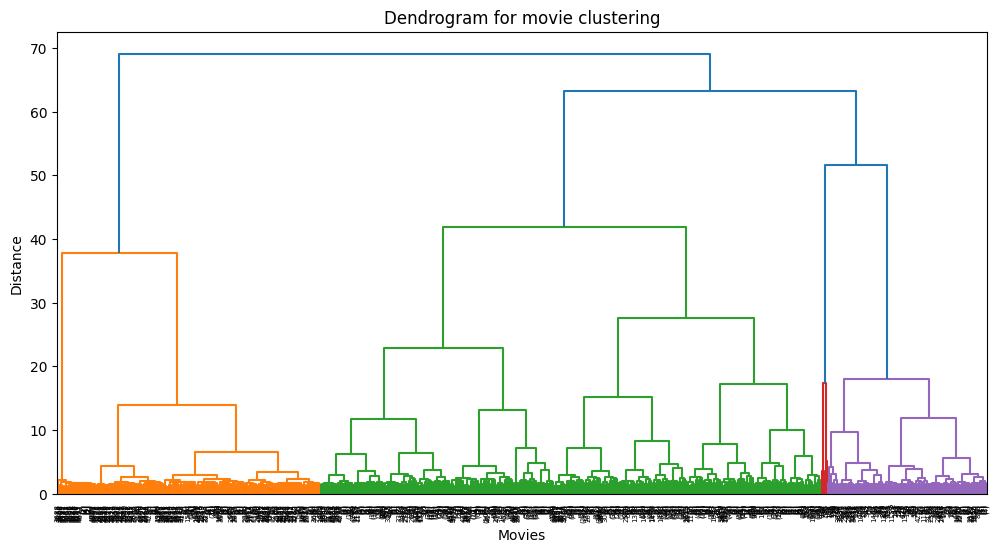

In [31]:
Z = linkage(X, method='ward')

#Plotting dendogram
plt.figure(figsize=(12,6))
dendrogram(Z, truncate_mode='level',p=10)
plt.title("Dendrogram for movie clustering")
plt.xlabel("Movies")
plt.ylabel("Distance")
plt.show()

Applying Agglomerative Clustering

In [32]:
hc = AgglomerativeClustering(n_clusters=5,metric='euclidean',linkage='ward')
df['cluster'] = hc.fit_predict(X)

#display movie cluster
print(df[['title','cluster']].head(10))

                                      title  cluster
0                                    Avatar        2
1  Pirates of the Caribbean: At World's End        2
2                                   Spectre        2
3                     The Dark Knight Rises        2
4                               John Carter        1
5                              Spider-Man 3        2
6                                   Tangled        4
7                   Avengers: Age of Ultron        2
8    Harry Potter and the Half-Blood Prince        2
9        Batman v Superman: Dawn of Justice        2


Analyzing the clusters

In [33]:
print(df['cluster'].value_counts())

cluster
1    2486
4    1556
0     502
2     250
3       6
Name: count, dtype: int64


Finding Top Words in Each Clusters

In [36]:
from collections import Counter

for cluster in range(5):
    cluster_texts = df[df['cluster'] == cluster]['processed_overview']
    words = ' '.join(cluster_texts).split()
    common_words = Counter(words).most_common(10)
    print(f"Cluster {cluster}: {common_words}")


Cluster 0: [('one', 93), ('life', 86), ('find', 84), ('world', 79), ('friend', 74), ('get', 72), ('new', 68), ('take', 68), ('man', 68), ('family', 67)]
Cluster 1: [('life', 585), ('find', 427), ('new', 401), ('one', 386), ('young', 321), ('year', 313), ('world', 311), ('friend', 304), ('get', 303), ('two', 298)]
Cluster 2: [('life', 63), ('world', 63), ('find', 51), ('new', 43), ('year', 41), ('must', 38), ('man', 34), ('one', 33), ('young', 31), ('help', 27)]
Cluster 3: [('year', 3), ('world', 3), ('man', 3), ('deadpool', 3), ('two', 2), ('jurassic', 2), ('park', 2), ('interstellar', 2), ('make', 2), ('story', 2)]
Cluster 4: [('life', 437), ('story', 244), ('find', 242), ('year', 237), ('young', 219), ('one', 214), ('new', 206), ('family', 199), ('world', 198), ('two', 187)]


Visualizing the clusters using PCA

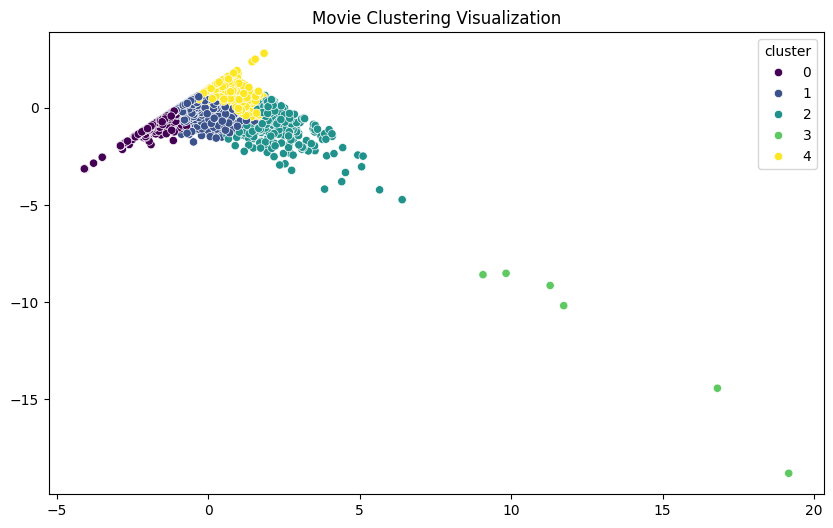

In [38]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['cluster'], palette='viridis')
plt.title("Movie Clustering Visualization")
plt.show()


In [39]:
from sklearn.metrics import accuracy_score
accuracy_score(df['cluster'], df['cluster'])

1.0